In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

In [2]:
prototxtPath = 'deploy.prototxt.txt'
weightsPath = 'res10_300x300_ssd_iter_140000.caffemodel'

faceNet = cv2.dnn.readNet(prototxtPath,weightsPath)
maskNet = model = torch.load('oct.pt',map_location='cpu')

In [3]:
maskNet = model = torch.load('oct.pt',map_location='cpu')

In [4]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
ori_image=cv2.imread('mymaskimg.jpg.jpg')

In [6]:
# while True:
#     cv2.imshow('img',ori_image)
    
#     if cv2.waitKey(0):
#         break
        
# cv2.destroyAllWindows()

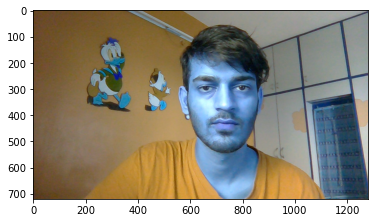

In [7]:
plt.imshow(ori_image)

In [8]:
ori_image.shape

(720, 1280, 3)

In [9]:
(h,w) = ori_image.shape[0:2]
h,w

(720, 1280)

In [10]:
blob = cv2.dnn.blobFromImage(image= ori_image,
                             scalefactor= 1.0,
                             size= (300,300),
                             mean= (104.0,177.0,123.0))

In [11]:
blob.shape

(1, 3, 300, 300)

In [12]:
faceNet.setInput(blob)

detections = faceNet.forward()

In [13]:
print('detections.shape -> ', detections.shape)

print('confidence -> ', detections[0,0,0,2])

print('since "confidence > 0.5" i.e. face is detected we will extract dimensions -> ',detections[0,0,0,3:7] )

detections.shape ->  (1, 1, 200, 7)
confidence ->  0.9999058
since "confidence > 0.5" i.e. face is detected we will extract dimensions ->  [0.46222767 0.21717578 0.67306066 0.7583098 ]


In [14]:
test_transforms = T.Compose([T.Resize((224,224)),
                             T.ToTensor(),
                            ])

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
image = ori_image.copy()

#loop over the detections
for i in range(detections.shape[2]):

    confidence = detections[0,0,i,2]
    
    if confidence>0.5:
        
        #we need the X,Y coordinates as integers
        box = detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY) = box.astype('int')
        
        #to ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY) = ( max(0,startX), max(0,startY))
        (endX,endY) = (min(w-1,endX), min(h-1,endY))
        
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        
        maskNet.eval()
        
        face = Image.fromarray(face)
        face = test_transforms(face).float()
        face = torch.autograd.Variable(face, requires_grad=True)
        face = face.unsqueeze(0)
        output = maskNet(face)
        conf, predicted = torch.max(output.data, 1)
        mask = predicted.item()

        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask == 0 else 'No Mask'
        
        color= (0,255,0) if label=='Mask' else (0,0,255)
               
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
        
cv2.imshow("Output",image)
cv2.waitKey(0)
cv2.destroyAllWindows()